In [216]:
def anomaly_skill(df):
    '''
    Use this for any question regarding an anomaly
    '''
    print('[INFO] Anomaly Skill called')
    import numpy as np
    from scipy import stats
    import pandas as pd
    from tabulate import tabulate
    import matplotlib.pyplot as plt
    from datetime import datetime
    log_df = df
    anomalies = {}

    ###########################################
    ### 1. Check for missing or null values ###
    ###########################################
    missing_values = pd.DataFrame(log_df.isnull().sum()).reset_index()
    missing_values.columns = ['Column', 'NA Count']
    missing_values = missing_values[missing_values['NA Count'] > 0]
    anomalies['missing_values'] = tabulate(missing_values, headers=missing_values.columns, tablefmt='pretty', showindex=False) if missing_values.shape[0] > 0 else 'No missing values'
    print('[INFO] Anomaly Skill: missing values checked')

    ################################
    ### 2. Detect duplicate rows ###
    ################################
    duplicate_rows = log_df[log_df.duplicated()]
    anomalies['duplicate_rows'] = len(duplicate_rows)
    print('[INFO] Anomaly Skill: duplicate rows checked')

    ##############################################
    ### 3. Identify and handle numeric columns ###
    ##############################################
    numeric_columns = log_df.select_dtypes(include=[np.number]).columns
    numeric_columns = numeric_columns[~numeric_columns.str.contains('id', case=False)]

    if not numeric_columns.empty:
        outliers_data = []

        for column in numeric_columns:
            correlation = np.corrcoef(log_df.index, log_df[column])[0, 1]
            
            # If the correlation is close to 1, skip outlier detection for this column
            if np.abs(correlation) > 0.95:  # Threshold to decide if it's linear
                continue

            Q1 = log_df[column].quantile(0.25)
            Q3 = log_df[column].quantile(0.75)
            
            IQR = Q3 - Q1
 
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers_in_column = log_df[(log_df[column] < lower_bound) | (log_df[column] > upper_bound)]
           
            outliers_in_column['distance_from_bound'] = outliers_in_column[column].apply(
                lambda x: lower_bound - x if x < lower_bound else x - upper_bound
            )
            
            outliers_sorted = outliers_in_column.sort_values(by='distance_from_bound', ascending=False)
            
            # Select the top 3 most extreme outliers for the column
            top_3_outliers = outliers_sorted.head(3)
            
            # 11. Append the top 3 outliers for this column to the list (row number, column, value, distance)
            for index, row in top_3_outliers.iterrows():
                outliers_data.append({
                    'numeric_column': column,
                    'row_number': index,
                    'outlier_value': row[column]
                })

        if outliers_data:
            outliers_df = pd.DataFrame(outliers_data)
        else:
            outliers_df = pd.DataFrame(columns=['numeric_column', 'row_number', 'outlier_value'])
        
        anomalies['numeric_outliers'] = tabulate(outliers_df, headers=outliers_df.columns, tablefmt='pretty', showindex=False) if not outliers_df.empty else 'No numerical anomalies'
    print('[INFO] Anomaly Skill: numerical outliers checked')

    ##################################
    ### 4. Infer timestamp columns ###
    ##################################
    timestamp_columns = []
    for col in log_df.columns:
        try:
            if 'date' in col.lower() or 'time' in col.lower(): 
                timestamp_columns.append(col)
        except Exception:
            continue

    def timing_resampler(df, interval, column):
        interval_counts = df.resample(interval, on=column).size()
        interval_df = pd.DataFrame(interval_counts).reset_index()
        interval_df.columns = [f'Interval_{interval}', 'Count']
        skew = interval_df['Count'].skew()
        kurt = interval_df['Count'].kurt()
        return (interval_df, skew, kurt, skew+ np.abs(kurt-3))

    def timing_outliers(interval_df):
        q1 = interval_df['Count'].quantile(0.25)
        q3 = interval_df['Count'].quantile(0.75)
        iqr = q3-q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        filtered_df = interval_df[(interval_df['Count'] > upper) | (interval_df['Count'] < lower)].reset_index(drop=True)
        return filtered_df

    def best_timing(df, ts_col):
        intervals = ['1min', '5min', '10min', '30min', '1H', '2H', '3H', '6H', '12H', '1D']
        res = []
        for i in intervals:
            data, skew, kurt, total = timing_resampler(df, i , ts_col)
            if len(data) == 0:
                pass
            res.append((i, data, skew, kurt, total))

        if len(res) == 0:
            return 'NA', pd.DataFrame()

        res.sort(key=lambda x:x[-1])
        best_interval = res[0][0]
        best_df = timing_outliers(res[0][1])
        return best_interval, best_df

    if timestamp_columns:
        for ts_col in timestamp_columns:
            log_df[ts_col] = pd.to_datetime(log_df[ts_col], errors='coerce')
            interval, data = best_timing(log_df, ts_col)
            if len(data) != 0 and interval != 'NA':
                data = data.sort_values(by='Count', ascending=False)
                anomalies[f'timestamp_freq_anomaly_{ts_col}_{interval}'] = tabulate(data, headers=data.columns, tablefmt='pretty', showindex=False)
    print('[INFO] Anomaly Skill: timestamp checked')

    ##################################################################
    ### 5. Identify categorical columns and detect rare categories ###
    ##################################################################
    categorical_columns = log_df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns[:10]:
        event_frequency = log_df[col].value_counts()
        event_frequency_df = pd.DataFrame(event_frequency).reset_index()
        if len(event_frequency_df) <= 10:
            continue
        event_frequency_df.columns = ['Value', 'Count']
        event_frequency_df = event_frequency_df.sort_values('Count', ascending=True)
        rarest = event_frequency_df.head(3)
        anomalies[f'Rare_values_in_{col}'] = tabulate(rarest, headers=rarest.columns, tablefmt='pretty', showindex=False)
    print('[INFO] Anomaly Skill: categorical columns checked')

    #################################
    ### 6. Identify error columns ###
    #################################
    non_numeric_columns = log_df.select_dtypes(exclude=[np.number, np.datetime64]).columns
    error_results = []

    for column in non_numeric_columns:
        anomaly = log_df[log_df[column].str.contains('anomaly|anomalies', case=False, na=False)]
        anomaly_count = len(anomaly)
        error = log_df[log_df[column].str.contains('error|errors', case=False, na=False)]
        error_count = len(error)
        warning = log_df[log_df[column].str.contains('warning|warn', case=False, na=False)]
        warning_count = len(warning)
        res = [('anomalies',anomaly_count), ('errors', error_count), ('warnings', warning_count)]
        res_dic = {}
        for check, count in res:
            if count > 0:
                res_dic[check] = count
        if len(res_dic) > 0:
            error_results.append((column, str(res_dic)))

    if len(error_results) > 0:
        error_results_df = tabulate(error_results, headers=['Column', 'Error Counts'], tablefmt='grid')
        anomalies['Error Checks'] = error_results_df

    ########################
    ### add in timestamp ###
    ########################
    anomalies['ANOMALY CHECK DATE'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    ##################################
    ### Ploting and returning path ###
    ##################################
    anomaly_table = [(key, str(value)) for key, value in anomalies.items()]
    anomaly_table = tabulate(anomaly_table, headers=['Check', 'Details'], tablefmt='grid')

    fig, ax = plt.subplots(figsize=(8, 4))  
    ax.axis('off')  
    plt.text(0.5, 0.5, anomaly_table, family='monospace', ha='center', va='center', fontsize=12)


    png_path = "tabulated_anomalies.png"
    plt.savefig(png_path, bbox_inches='tight', dpi=300)

    return png_path

In [214]:
import pandas as pd
import numpy as np
from scipy import stats
import yaml
from tabulate import tabulate

df_mac = pd.read_csv('../../../data/Mac_2k.log_structured.csv')
df_mac_anomaly = anomaly_skill(df_mac)
df_mac_anomaly_table = [(key, str(value)) for key, value in df_mac_anomaly.items()]
mac_table = tabulate(df_mac_anomaly_table, headers=['Check', 'Details'], tablefmt='grid')

[INFO] Anomaly Skill called
[INFO] Anomaly Skill: missing values checked
[INFO] Anomaly Skill: duplicate rows checked
[INFO] Anomaly Skill: numerical outliers checked
[INFO] Anomaly Skill: timestamp checked
[INFO] Anomaly Skill: categorical columns checked


[INFO] Anomaly Skill called
[INFO] Anomaly Skill: missing values checked
[INFO] Anomaly Skill: duplicate rows checked
[INFO] Anomaly Skill: numerical outliers checked
[INFO] Anomaly Skill: timestamp checked
[INFO] Anomaly Skill: categorical columns checked


'tabulated_anomalies.png'

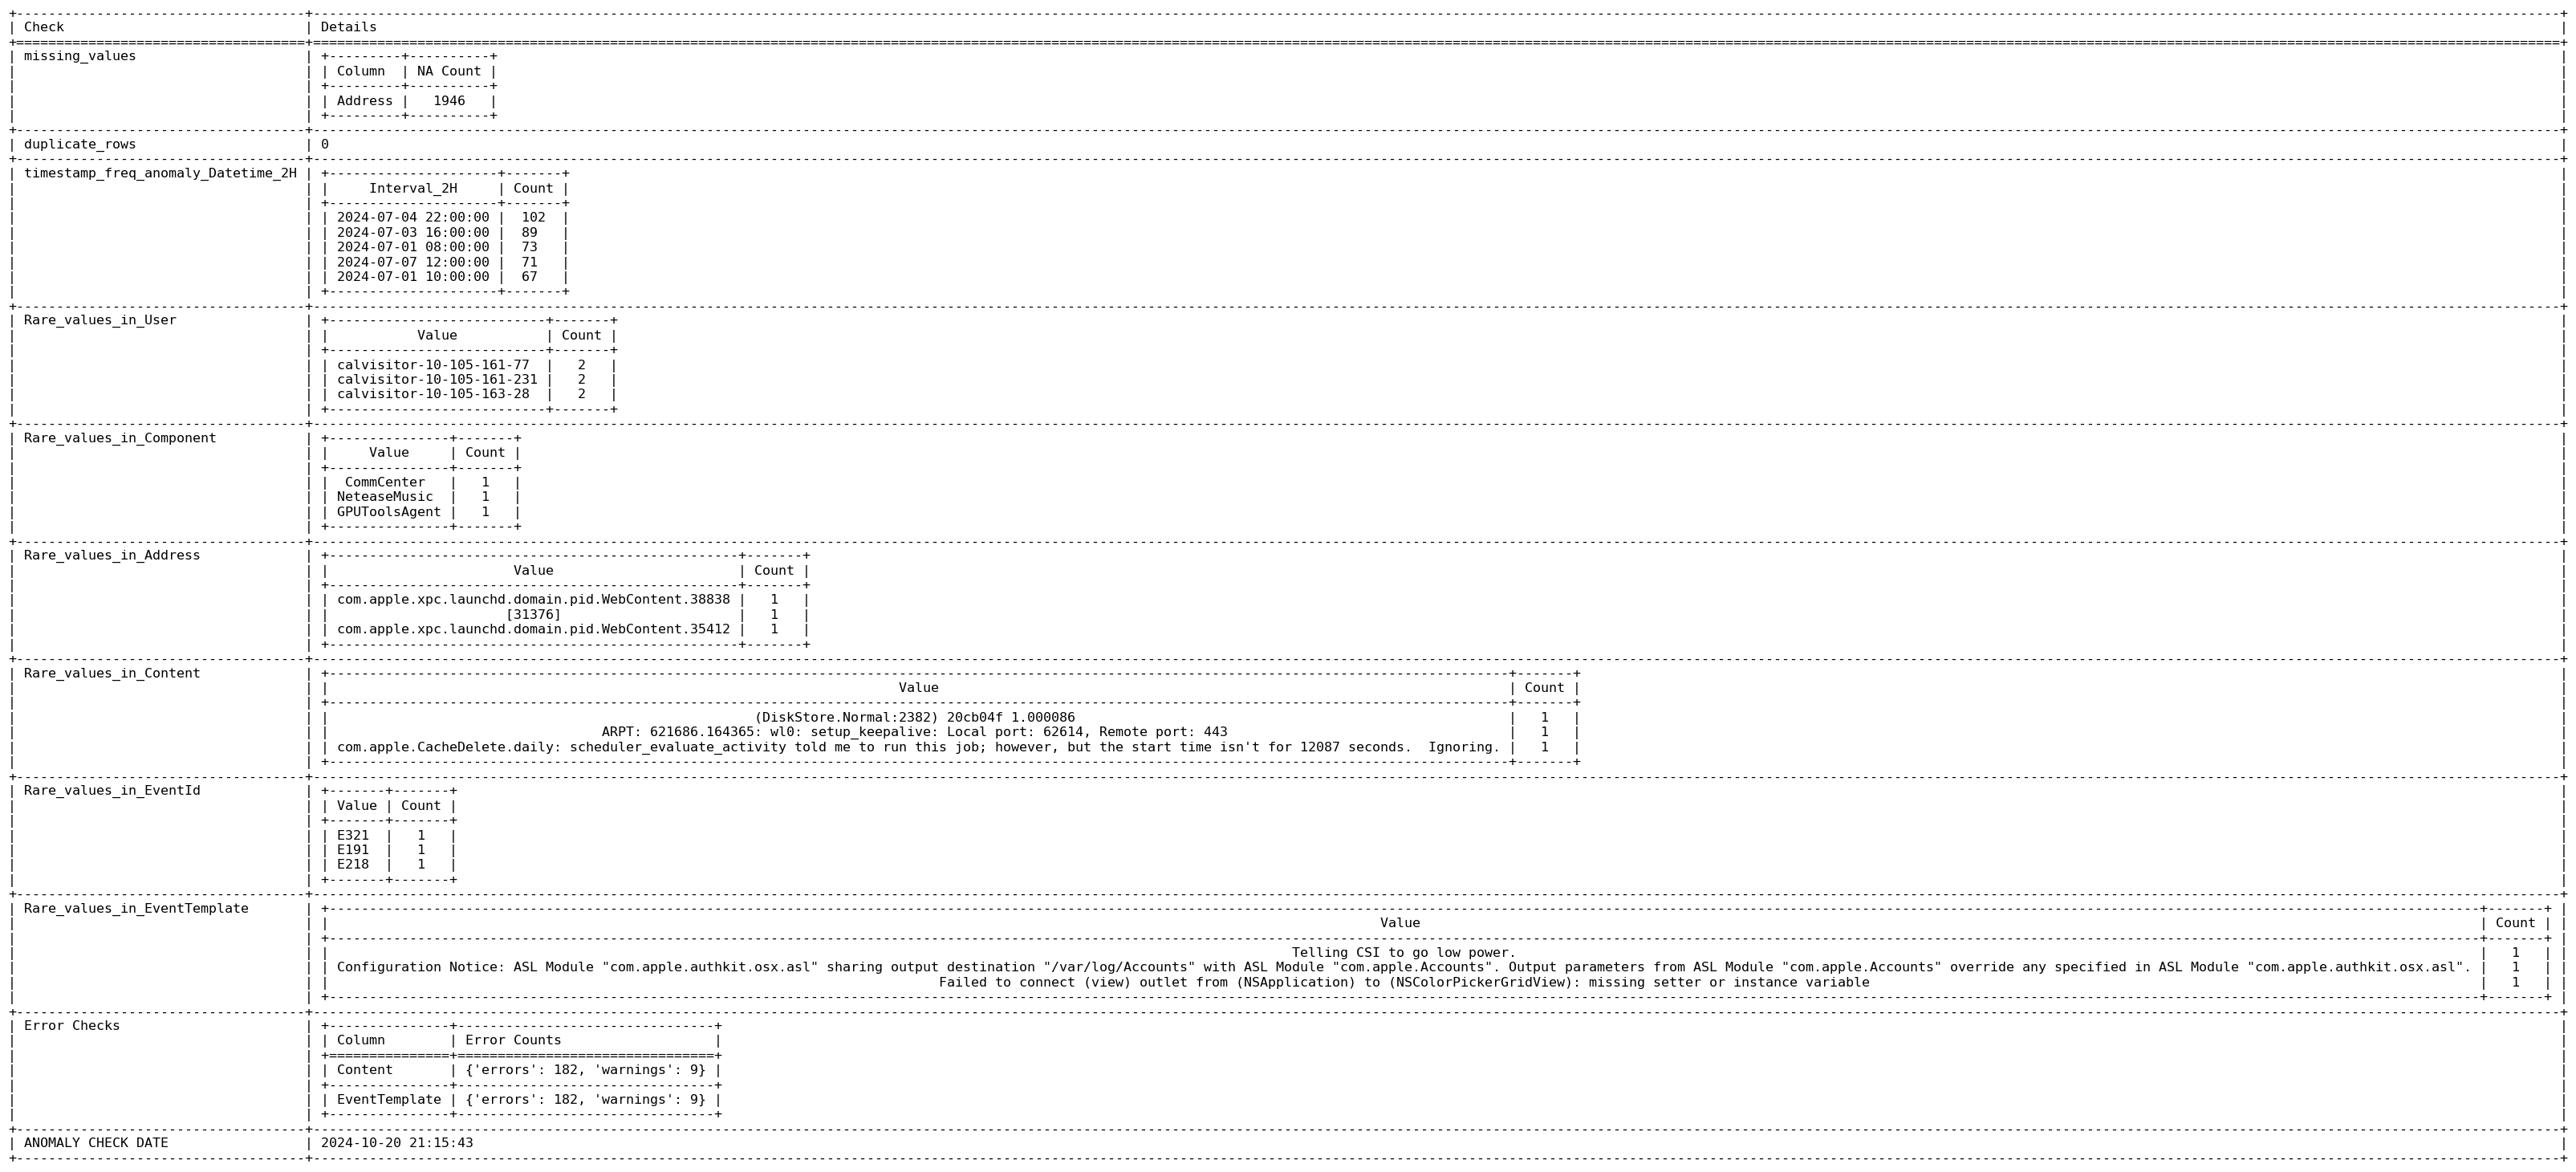

In [217]:
anomaly_skill(df_mac)

In [52]:
def timing_resampler(df, interval, column):
    interval_counts = df.resample(interval, on=column).size()
    interval_df = pd.DataFrame(interval_counts).reset_index()
    interval_df.columns = [f'Interval_{interval}', 'Count']
    skew = interval_df['Count'].skew()
    kurt = interval_df['Count'].kurt()
    return (interval_df, skew, kurt, skew+ np.abs(kurt-3))

def timing_outliers(interval_df):
    q1 = interval_df['Count'].quantile(0.25)
    q3 = interval_df['Count'].quantile(0.75)
    iqr = q3-q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered_df = interval_df[(interval_df['Count'] > upper) | (interval_df['Count'] < lower)].reset_index(drop=True)
    return filtered_df

def best_timing(df):
    intervals = ['1min', '5min', '10min', '30min', '1H', '2H', '3H', '6H', '12H', '1D']
    res = []
    for i in intervals:
        data, skew, kurt, total = timing_resampler(df, i , 'Datetime')
        if len(data) == 0:
            pass
        res.append((i, data, skew, kurt, total))

    if len(res) == 0:
        return pd.DataFrame()

    res.sort(key=lambda x:x[-1])
    best_interval = res[0][0]
    best_df = timing_outliers(res[0][1])
    return best_interval, best_df


    
best_timing(df_mac)
#timing_helper(df_mac, '3H', 'Datetime')

('2H',
           Interval_2H  Count
 0 2024-07-01 08:00:00     73
 1 2024-07-01 10:00:00     67
 2 2024-07-03 16:00:00     89
 3 2024-07-04 22:00:00    102
 4 2024-07-07 12:00:00     71)

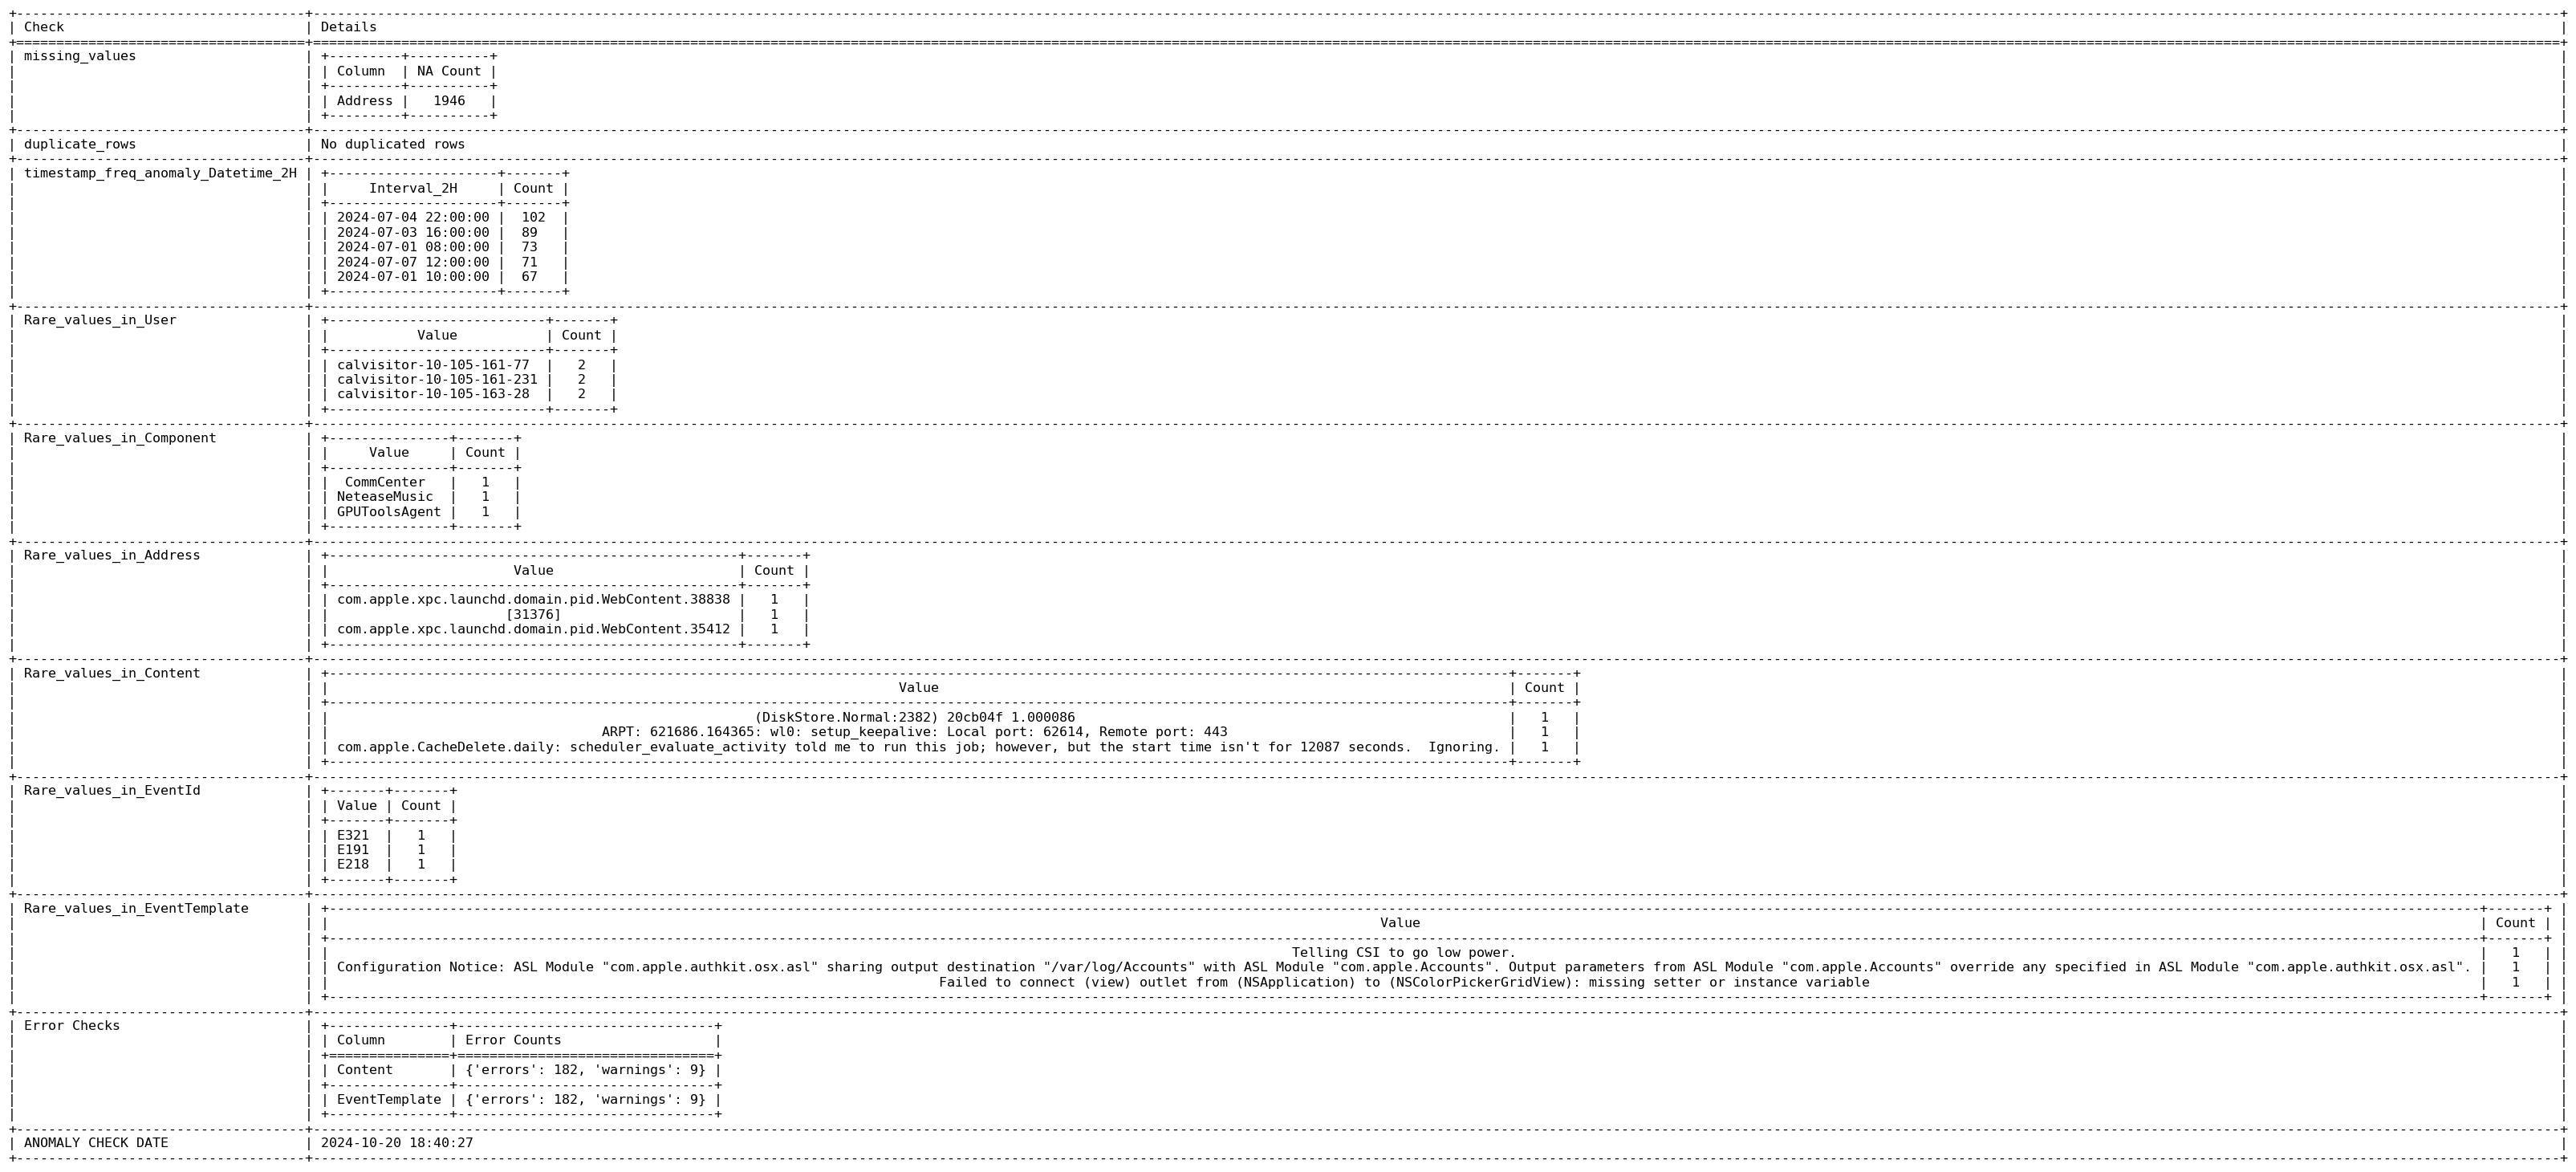

In [215]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))  
ax.axis('off')  
plt.text(0.5, 0.5, mac_table, family='monospace', ha='center', va='center', fontsize=12)


png_path = "tabulated_anomalies.png"
plt.savefig(png_path, bbox_inches='tight', dpi=300)

In [54]:
from pprint import pprint

df_credit_card = pd.read_csv('../../../logs/Credit card transactions - India - Simple.csv')
pprint(anomaly_skill(df_credit_card))

[INFO] Anomaly Skill called
[INFO] Anomaly Skill: missing values checked
[INFO] Anomaly Skill: duplicate rows checked
[INFO] Anomaly Skill: numerical outliers checked
[INFO] Anomaly Skill: timestamp checked
[INFO] Anomaly Skill: categorical columns checked
[INFO] Anomaly Skill: text columns checked
{'duplicate_rows': 'No duplicated rows',
 'missing_values': 'No missing values',
 'numeric_outliers':      index  Amount
15      15  647116
17      17  986379
19      19  735566
21      21  809623
22      22  467014
..     ...     ...
344    344  515263
346    346  934683
348    348  654519
349    349  958047
351    351  653161

[224 rows x 2 columns],
 'timestamp_freq_anomaly_Date': Date
2013-10-04    56
2013-10-05    48
2013-10-06    44
2013-10-07    50
2013-10-08    40
              ..
2015-05-22    38
2015-05-23    46
2015-05-24    48
2015-05-25    39
2015-05-26    46
Length: 596, dtype: int64}
